# 分子片段、片段指纹与指纹重要性分析

## 1.分子片段生成
分子片段（Molecular Fragments）是一组相连的原子，并可能包含有相关官能团。在rdkit中提供了一系列用于分析、操作分子片段的工具。说起来比较抽象，操作起来也比较抽象。
* 获取官能团库：RDConfig.RDDataDir目录下的'FunctionalGroups.txt'
* 根据官能团库实例化一个参数器：FragmentCatalog.FragCatParams()

In [1]:
import os
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import RDConfig
from rdkit.Chem import FragmentCatalog
fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
fparams = FragmentCatalog.FragCatParams(1, 6, fName)

In [2]:
# 感兴趣的可以查看一下该库的内容
with open(fName) as f:
    file = f.read()
# print(file)

* 查看库中包含的官能团数量：GetNumFuncGroups()
* 查看每个官能团对应的基团：GetFuncGroup()

39


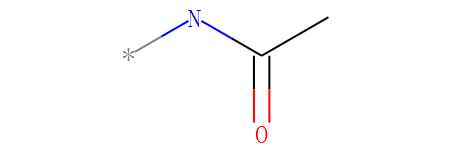

In [3]:
print(fparams.GetNumFuncGroups())
m = fparams.GetFuncGroup(0)
m

In [4]:
Draw.MolToFile(m, 'data/fragments_fp_1.png', (150, 150))

* 传入参数器，创建一个片段存储器：FragmentCatalog.FragCatalog()<br />
产生的分子片段都会存储在该对象中<br />
* 创建一个片段生成器：FragmentCatalog.FragCatGenerator()<br />
通过该对象生成片段<br />
* 计算分子片段：AddFragsFromMol()
* 查看分子片段数量：GetNumEntries()

In [5]:
m = Chem.MolFromSmiles('OCC=CC(=O)O')
fcat = FragmentCatalog.FragCatalog(fparams)
fcgen = FragmentCatalog.FragCatGenerator()
fcgen.AddFragsFromMol(m, fcat)
fcat.GetNumEntries()

3

* 通过存储器查看片段：fcat.GetEntryDescription()<br />
尖括号中的内容：表示与片段相连的官能团，以下面的结果为例：<br />
第0号片段中，对应着一个乙基片段，该乙基与一个羟基相连。<br />
第1号片段中，对应着一个乙烯片段，该乙烯与一个羧基相连。

In [6]:
print(fcat.GetEntryDescription(0))
print(fcat.GetEntryDescription(1))

C<-O>C
C=C<-C(=O)O>


关于官能团的详细信息，可以通过下述方法获取：
* 向存储器传入分子片段id，获取片段中所包含的官能团编号：fcat.GetEntryFuncGroupIds()
* 向参数器传入官能团编号，获取官能团对应的mol对象：fparams.GetFuncGroup()

In [7]:
print(list(fcat.GetEntryFuncGroupIds(0)))
funcgroup = fparams.GetFuncGroup(34)
print(Chem.MolToSmarts(funcgroup))
print(funcgroup.GetProp('_Name'))

[34]
*-[O&D1]
-O


提取得到的片段是层级结构，小片段在最底层，逐渐合并形成大片段。可以查看一个小片段形成了哪些大片段。
* 根据id获取片段：fcat.GetEntryDescription()
* 获取上级片段id：fcat.GetEntryDownIds()

In [8]:
print(fcat.GetEntryDescription(0))
list(fcat.GetEntryDownIds(0))

C<-O>C


[2]

* 根据上级片段id，获取上级片段信息

In [9]:
fcat.GetEntryDescription(2)

'C<-C(=O)O>=CC<-O>'

## 2.片段指纹生成
* 先将多个分子的片段汇总到一个片段存储器中

In [10]:
ms = [Chem.MolFromSmiles('OCC(NC1CC1)CCC'), Chem.MolFromSmiles('OCC=CC(=O)O')]
fcat = FragmentCatalog.FragCatalog(fparams)
for m in ms:
    fcgen.AddFragsFromMol(m, fcat)
fcat.GetNumEntries()

17

存储器收集完所有片段后，再用它来生成分子指纹
* 创建一个片段指纹生成器：FragFPGenerator()
* 传入分子和存储器来生成指纹：GetFPForMol(mol, fcat)
* 以字符串形式查看指纹：ToBitString()
* 查看指纹中哪些位是有效的：GetOnBits()

In [11]:
fpgen = FragmentCatalog.FragFPGenerator()
fp1 = fpgen.GetFPForMol(ms[1], fcat)
print(fp1.ToBitString())
print(list(fp1.GetOnBits()))

10000000000000011
[0, 15, 16]


可以用处理一般分子指纹的方法来处理片段分子指纹，例如寻找相同的片段
* 先对分子指纹做一步“&”位运算，两个指纹都为1时，结果为1，否则为0
* 获取两个指纹中都出现的片段：GetOnBits()
* 查看片段信息：GetEntryDescription()

In [12]:
fp0 = fpgen.GetFPForMol(ms[0], fcat)
andfp = fp0 & fp1
onbit = list(andfp.GetOnBits())
fcat.GetEntryDescription(onbit[0])

'C<-O>C'

也可以按上述思路查看一下哪些片段导致了分子的不同
* 对分子指纹做“^”运算，两个指纹相同时，结果为0，否则为1。再做一步“&”运算
* 按上述方法查看相异片段

In [13]:
dis = fp0 ^ fp1
combinedfp = fp0 & dis
onbit = list(combinedfp.GetOnBits())
fcat.GetEntryDescription(onbit[-1])

'CCCC(C<-O>)N<-cPropyl>'

## 3.指纹重要性分析
这里主要介绍指纹对离散标签的重要性分析。在rdkit.ML.InfoTheory.rdInfoTheory.InfoBitRanker中提供了对指纹分析的功能。这个类可以根据分子指纹和离散标签，对特征进行计算和排序，看看哪些特征对活性比较重要。
* 先对163个分子生成片段指纹，完整代码如下

In [14]:
sdf_file = os.path.join(RDConfig.RDDocsDir, 'Book/data/bzr.sdf')
suppl = Chem.SDMolSupplier(sdf_file)
sdms = [x for x in suppl]

# 获取官能团库
fName = os.path.join(RDConfig.RDDataDir, 'FunctionalGroups.txt')
# 片段参数器
fparams = FragmentCatalog.FragCatParams(1, 6, fName)
# 片段存储器
fcat = FragmentCatalog.FragCatalog(fparams)
# 片段生成器
fcgen = FragmentCatalog.FragCatGenerator()
# 片段指纹生成器
fpgen = FragmentCatalog.FragFPGenerator()
# 汇总所有片段
for m in sdms:
    fcgen.AddFragsFromMol(m, fcat)
# 生成片段指纹
fps = [fpgen.GetFPForMol(x, fcat) for x in sdms]
print(len(fps), fps[0].GetNumBits())

163 8266


* 信息增益（infoGain）分析，实例化一个排序对象：InfoBitRanker(nBits, nClasses, infoType)<br />
nBits：指纹长度<br />
nClasses：类别数量，需要和标签满足的关系：0 <= 标签 < 类别数量<br />
infoType：度量指标。默认使用rdInfoTheory.InfoType.ENTROPY，即信息增益作为比较标准，它反映了使用某个特征进行分类后，系统混乱程度降低的多少，数值越大表明特征越重要。<br />

In [15]:
from rdkit.ML import InfoTheory
ranker = InfoTheory.InfoBitRanker(len(fps[0]), 2)

* 获取每个分子的活性信息：GetDoubleProp('ACTIVITY')
* 以7作为标准对活性离散化，大于7为1，小于7为0
* 根据指纹和类别进行投票：AccumulateVotes(fp, act)
* 获取前5个重要特征：GetTopN(5)
* 依次输出特征id、信息增益、特征为1类别中的无活性分子数、特征为1类别中的有活性分子数。

In [16]:
acts = [x.GetDoubleProp('ACTIVITY') for x in sdms]
for i,fp in enumerate(fps):
    act = int(acts[i]>7)
    ranker.AccumulateVotes(fp,act)
top5 = ranker.GetTopN(5)
for id, gain, n0, n1 in top5:
    print(int(id), '%.3f'%gain, int(n0), int(n1))

698 0.081 20 17
222 0.073 23 25
378 0.073 30 43
196 0.073 30 43
1207 0.073 0 25


* 加入偏置，以信息增益为例，重新设置infoType
* 设置偏置类别：SetBiasList()<br />
在这种模式下，一个特征与所设置了偏置类别的相关性要高于所有非偏置类别，例如设置偏置类别为4，某位特征为1对应的标签中，类别为4的数量应该大于其他类别的数量。

In [17]:
ranker = InfoTheory.InfoBitRanker(len(fps[0]), 2, InfoTheory.InfoType.BIASENTROPY)
ranker.SetBiasList((0,))
acts = [x.GetDoubleProp('ACTIVITY') for x in sdms]
for i,fp in enumerate(fps):
    act = 0 if acts[i]<7 else 1
    ranker.AccumulateVotes(fp, act)
top5 = ranker.GetTopN(5)
for id, gain, n0, n1 in top5:
    print(int(id), '%.3f'%gain, int(n0), int(n1))

698 0.081 20 17
222 0.073 23 25
378 0.073 30 43
196 0.073 30 43
2375 0.062 5 0


* 使用卡方检验（chi squared test），将infoType设置为如下参数，其他相同

In [18]:
ranker = InfoTheory.InfoBitRanker(len(fps[0]), 2, InfoTheory.InfoType.CHISQUARE)
for i,fp in enumerate(fps):
    act = int(acts[i]>7)
    ranker.AccumulateVotes(fp, act)
top5 = ranker.GetTopN(5)
for id, gain, n0, n1 in top5:
    print(int(id), '%.3f'%gain, int(n0), int(n1))

698 20.023 20 17
222 17.451 23 25
378 16.242 30 43
196 16.242 30 43
2375 14.861 5 0


* 带偏置的卡方检验同上，重新设置infoType为InfoTheory.InfoType.BIASCHISQUARE即可